In [1]:
%matplotlib notebook
# Graph histogram and cumulative distribution for passed tests v. duration
# Filters can be used to limit the input.
# For example, to risky ips and to foreign ips

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import mplcursors      # Allows interactive matplotlib graphs

# Local library to read and prep data from dmv akts events in splunk
import dmv_test_input as dti 

def read_log(case=1, field="duration"):
    # Read and prepare the dmv_akts. Case=1 ... sample ... =2 ... akts database

    # Read and cleanse data from akts log and risk database
    df, risk = dti.dmv_risk_input(case=2, save=False)    
    
    df["elapsed"] = abs(df['TestEndDateTime'] - df['TestStartDateTime']).dt.total_seconds()/60.
    df["passed"]  = (df.Result=="P")
    
    # Drop negative duration since they must be in error
    # Drop long durations because the chance of error is high
    
    df = df[ (df.duration>0) & (df.duration<120) & (df.elapsed<120)].reset_index()
    
    return df, risk

def find_intersect(x, y, x0):
    # Intepolate y0=f(x0) when f(x) is a discrete set of points {(x[i], y[i])}
    # Caution x must be between endpoints; x is monotonically increasing
    for i in list(range(len(df.duration)))[1:]:
        if x[i] > x0:
            m = (x[i]-x[i-1]) /( y[i]-y[i-1])
            return y[i] + m*(x0 - x[i-1])

def lbl_point(ax, x0, y0, tx, ty):
    # annotate a point with an arrow with test offset by (tx,ty)*1/8 inch (9 points)
    inc = 9
    point = (x0, y0)          # point in axis
    label = (tx*inc, ty*inc)  # offset position of text from point
    ax.annotate(f'{y0:.0f}', 
                xy=point, xycoords='data',
                xytext=label, textcoords='offset points',
                arrowprops=dict(facecolor='black', shrink=0.05))


In [25]:
def graph_comparison(x, fw=8, fh=7):
    # Graph compares duration distributions for passing tests to before the cutoff
    # These tests were geofenced starting 10/27
    
    def graph_histo(df):   
        # Graph histo of all tests and tests before cutoff
 
        fig, ax = plt.subplots(figsize=(fw, fh))
 
        # All the passed tests
        all_time      = ax.hist(df.duration, 
                        bins=25, histtype="step", 
                        label="All Passed Tests")
        # Passed before the cutoff date. Shows how it was before geofencing.
        before_cutoff = ax.hist(
                        df[(df.TestStartDateTime <= C.time_cutoff)].duration,
                        bins=25, histtype="step", 
                        label=f'Before Geofencing {C.time_cutoff}')
        # Draw x=0 axis
        ax.axhline(y=0, color="gray", linewidth=1)
        # Display the changept and median
        ax.axvline(x=C.changept, color="red", linewidth=1, ls=":", label=f"{C.changept=} min")
        ax.axvline(x=median, color="green", linewidth=1, ls=":", label=f"{median=:.1f} min")

        ax.set_title(C.title_histo)
        ax.set_xlabel(f'Duration (min)')
        ax.set_ylabel(f'Count of Passed Tests')
        ax.grid(False)
        ax.legend(loc='upper right')
        plt.show
        # Return plt objects so calculated distributions can be used
        return all_time, before_cutoff

    def histo_data(before_cutoff, all_time):
        # Use the counts calculated by plt.hist to find:
        # before_cutoff ... # passed tests before time_cutoff
        # all_time  ....... # passed tests that during all time
        # 
        # Exclude last duration, the outer edge of last bin. 
        # In following we use the calculated results made by plt.hist
        #    *[0] ... counts
        #    *[1] ... leading edges of the bins

        dr = pd.DataFrame(before_cutoff[1][:-1], columns=['duration'])
        dr['before_cutoff'] = before_cutoff[0]
        dr['all_time'] = all_time[0]
        return dr
    
    def graph_cum(df):
        # Graph the cumulative distribution
        
        df['cum_all_time'] = df['all_time'].cumsum()
        df['cum_before_cutoff'] = df['before_cutoff'].cumsum()

        fig, ax = plt.subplots(figsize=(8, 4))
        ax.plot(df.duration, df.cum_before_cutoff, label=f'cum before {C.time_cutoff}')
        ax.plot(df.duration, df.cum_all_time, label='cum all time')
        ax.axvline(x=C.changept, color="red", linewidth=1, ls=":", label=f"{C.changept=} min")
        ax.axvline(x=median, color="green", linewidth=1, ls=":", label=f"{median=:.1f} min")
        
        # Label intersection of median with cdf with arrow and value
        intersect_all = find_intersect(df.duration, df.cum_all_time, median)
        intersect_before = find_intersect(df.duration, df.cum_before_cutoff, median)
        lbl_point(ax, median, intersect_all, -8, 1)
        lbl_point(ax, median, intersect_before, -8, 1)
        
        ax.set_title(C.title_cum)
        ax.set_xlabel(f'Duration (min)')
        ax.set_ylabel(f'Count')
        ax.legend(loc='center right')
        ax.grid(True)
        plt.show()
#     import pdb; pdb.set_trace()
 
    all_time, before_cutoff = graph_histo(x)
    dr = histo_data(all_time, before_cutoff)
    graph_cum(dr)
    return dr

def filter_prep(df):
    # Exclude tests that take a long time or have questionable time
    # Also minimizes the effect of long tail for short duration tests
    result = df[(df.duration > 0) & (df.duration <= 40) 
           & (df.elapsed > 0) & (df.elapsed < 60)].reset_index()
    # Replace country==Nan with unknown. They will be treated as non-native
    result.country.fillna('unknown', inplace=True)
    # Restrict to passed tests
    return result[result.Result=="P"]   

def filter_risky(df):
    # Filter raw data to include passed tests that used risky ip addresses
    result = filter_prep(df)
    
    # Restrict to tests from ip addresses that are risky
    result = result[result.score > C.risk_cutoff]
    return result

def filter_foreign(df):
    # Filter raw data to include passed tests that used ip from outside USA
    result = filter_prep(df)
    
    # Restrict to tests from ip addresses outside USA
    result['native'] = result.country.isin(['United States', 'Puerto Rico'])
    result = result[~result.native]    
    return result

def filter_risky_usa(df):
    # Filter raw data to include passed tests that use risky ips 
    # that are from inside USA
    result = filter_prep(df)
    # Exclude tests from ip addresses outside USA
    result['native'] = result.country.isin(['United States', 'Puerto Rico']) 
    result['risky']  = result.score > C.risk_cutoff
    result = result[result.native & result.risky]    
    return result

def filter_risky_foreign(df):
    # Filter raw data to include passed tests that use risky ips 
    # that are from inside USA
    result = filter_prep(df)
    # Exclude tests from ip addresses outside USA
    result['native'] = result.country.isin(['United States', 'Puerto Rico']) 
    result['risky']  = result.score > C.risk_cutoff
    result = result[~result.native | result.risky]    
    return result

class Parameters():
    def __init__(self):
        self.time_cutoff = '11/15/2021'
        self.risk_cutoff = 20
        self.changept = 14.5
        self.rate = 0.67
        self.title_histo = f'Passed v Duration - IP Risk > {self.risk_cutoff} - Compare to Before GeoFencing'
        self.title_cum   = f'Accumulated Passed Tests - IP Risk > {self.risk_cutoff}'

In [8]:
df, risk = read_log(case=2)

Original length of sample data is 179142
2862 tests with Result, IPAddress, TotalScore = NaN dropped
Extra ip address dropped in 1183 tests


Risk.find: Could not find IPv4Address for ip_string='2001'
Risk.find: Could not find IPv4Address for ip_string='2001'
Risk.find: Could not find IPv4Address for ip_string='2001'
Risk.find: Could not find IPv4Address for ip_string='2001'
Risk.find: Could not find IPv4Address for ip_string='2001'
Risk.find: Could not find IPv4Address for ip_string='2001'


<IPython.core.display.Javascript object>


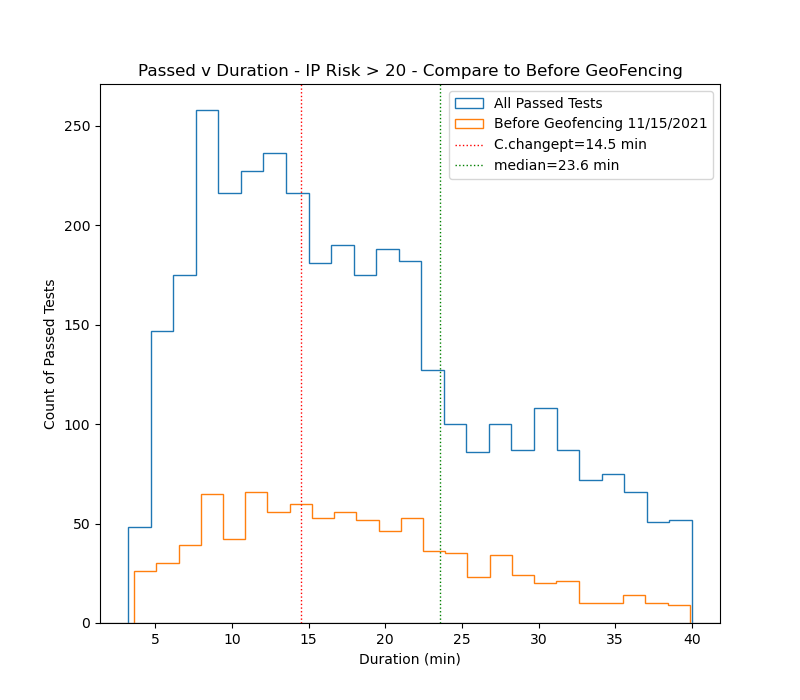

<IPython.core.display.Javascript object>


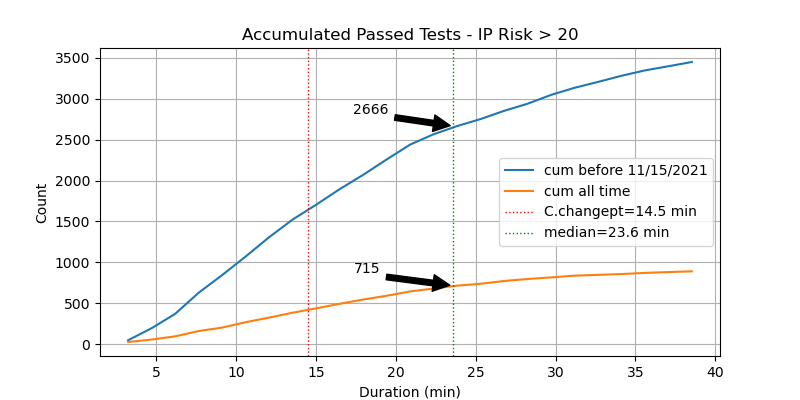

<IPython.core.display.Javascript object>


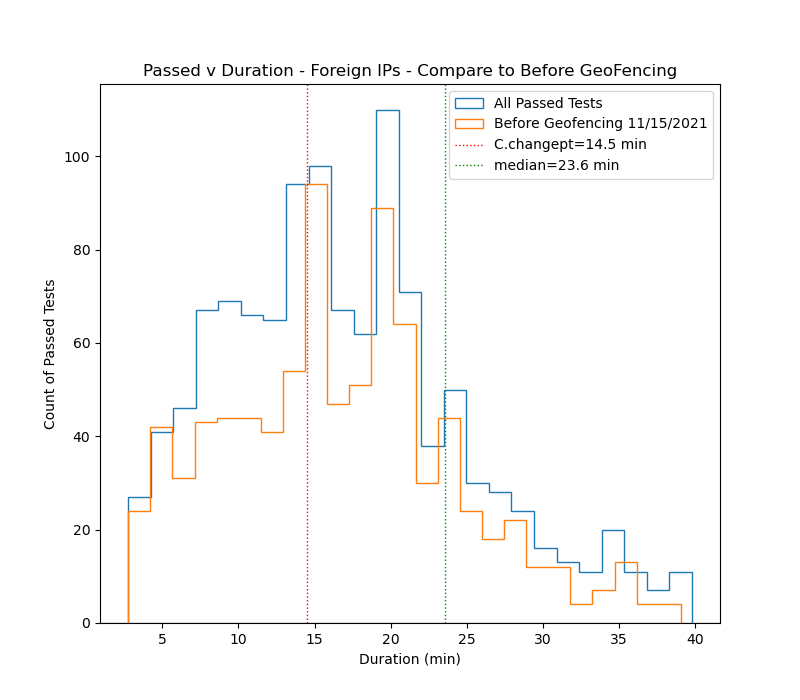

<IPython.core.display.Javascript object>


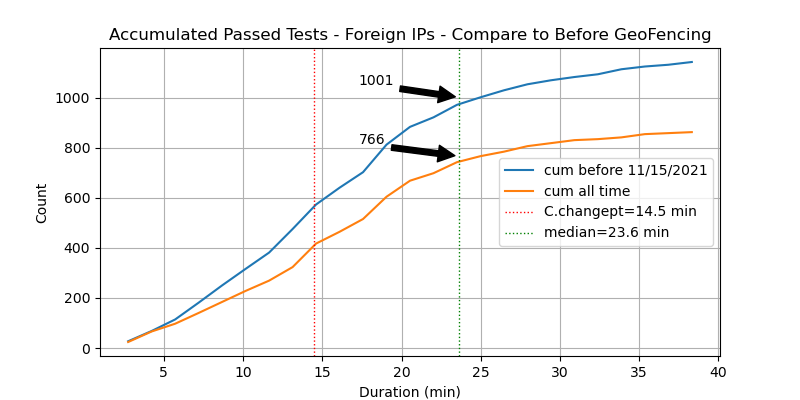

<IPython.core.display.Javascript object>


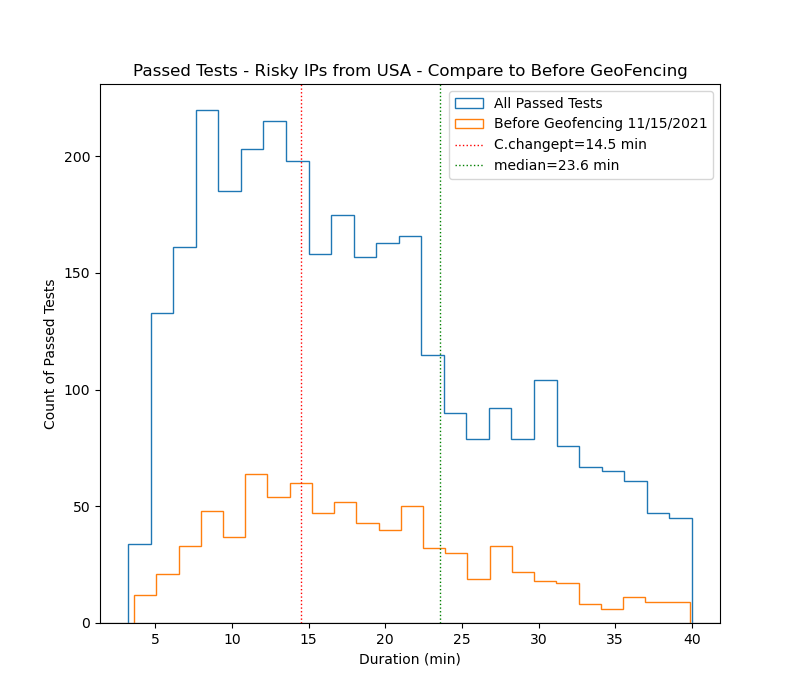

<IPython.core.display.Javascript object>


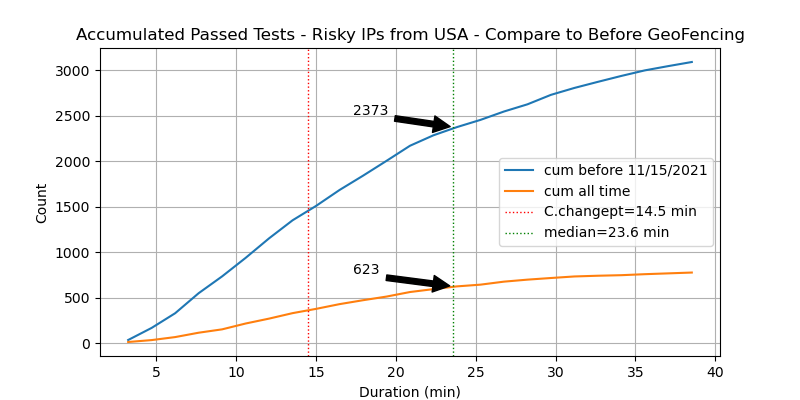

<IPython.core.display.Javascript object>


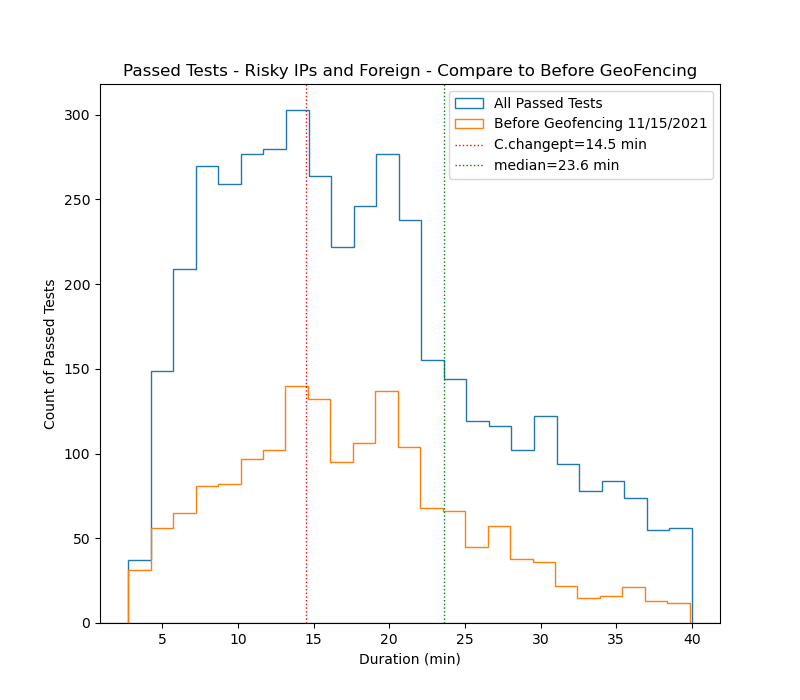

<IPython.core.display.Javascript object>


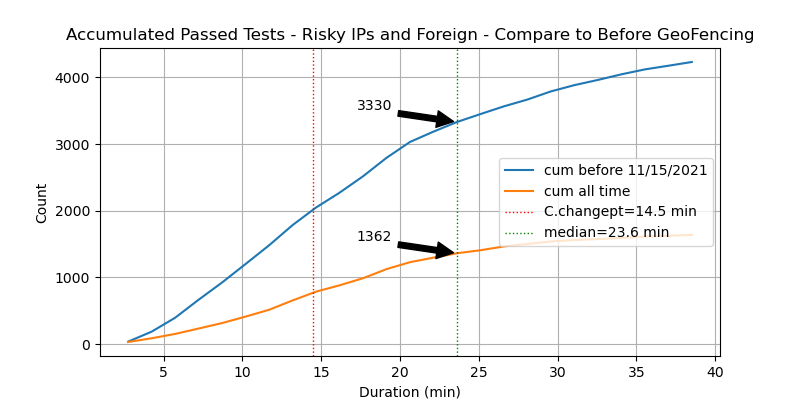

In [26]:
C = Parameters()

# Find median of all the data before it is filtered
median = df.duration.median()

# Compare passed tests for risky ip addresses
dr1 = graph_comparison( filter_risky(df) )

# Compare passed tests for foreign ip addresses
C.title_histo = f'Passed v Duration - Foreign IPs - Compare to Before GeoFencing'
C.title_cum   = f'Accumulated Passed Tests - Foreign IPs - Compare to Before GeoFencing'
dr2 = graph_comparison( filter_foreign(df) )

C.title_histo = f'Passed Tests - Risky IPs from USA - Compare to Before GeoFencing'
C.title_cum   = f'Accumulated Passed Tests - Risky IPs from USA - Compare to Before GeoFencing'
dr3 = graph_comparison( filter_risky_usa(df) )

C.title_histo = f'Passed Tests - Risky IPs and Foreign - Compare to Before GeoFencing'
C.title_cum   = f'Accumulated Passed Tests - Risky IPs and Foreign - Compare to Before GeoFencing'
dr4 = graph_comparison( filter_risky_foreign(df) )